## Carga del dataset

Esta celda se encargará de bajar el dataset a vuestro ordenador. Tened en cuenta que puede haber fallos, ya que el repositorio de UCI desde donde se descarga tiene muchas peticiones simultáneas.

In [18]:
import os
import numpy as np
from scipy.special import erf
from scipy.io import loadmat
from tensorflow.keras.utils import get_file
from sklearn.model_selection import KFold


def download_dataset(directory):

    if not os.path.isdir(directory):
        os.makedirs(directory)

    filename = 'Isolet.mat'
    url = 'https://jundongl.github.io/scikit-feature/files/datasets/Isolet.mat'

    get_file(filename, url, cache_dir=directory, cache_subdir='.')


def load_dataset(directory=None):
    directory = directory or './isolet/'
    download_dataset(directory=directory)
    dataset = load_data(directory + 'Isolet.mat')
    return dataset


def load_data(source):
    dataset = loadmat(source)
    return dataset['X'].astype(float), dataset['Y'].astype(int)


In [19]:
# Cargamos el dataset
data, label = load_dataset()

# One-hot encoding de label, debe tener shape (None, 26)
n_samples = len(label)
n_classes = len(np.unique(label))
label_onehot = np.zeros((n_samples, n_classes))
label_onehot[np.arange(n_samples), label[:, 0] - 1] = 1
label = label_onehot

## Normalizamos los datos de entrada

Normaliza los datos de entrada de la manera que quieras, con el objetivo de facilitar el entrenamiento de la red. Recuerda que, si vas a utilizar valores estadísticos de los datos, éstos sólo pueden ser obtenidos de los datos de la partición de train. Es decir, **no se puede aplicar la función fit (o fit_transform) sobre los datos de validación o test**.

In [20]:
# Clase para normalizar los datos (normalizaremos por media 0 y varianza 1)
class Normalize:

    def __init__(self):
        self.stats = None

    def fit(self, X):
        # TODO: guarda las estadísticas de X necesarias para hacer la transformación
        self.stats = (np.mean(X), np.std(X))
        return self

    def transform(self, X):
        X = (X - self.stats[0]) / self.stats[1]
        return X

    def fit_transform(self, X):
        mean = np.mean(X)
        std = np.std(X)
        return (X - mean) / std

## Diseña una función para crear tu propia red

Ya tienes los datos, es hora de hacer tu trabajo. Crea una función que te permita crear tu red en TensorFlow. Aunque el esqueleto que te proponemos abajo es una función sin parámetros, puedes poner tantos como quieras.

In [21]:
# Entrena un modelo creado sobre Tensorflow. El número de capas ocultas será de 2, con 50 neuronas por capa, 
# una regularización l2 de 0.01, y ReLU como función de activación para las capas ocultas.

import tensorflow
from matplotlib import pyplot
from tensorflow import keras
from keras.models import Sequential
from keras.layers import InputLayer
from keras.layers import Dense
from tensorflow.keras.regularizers import l2


fn_perdida = keras.losses.CategoricalCrossentropy() # Función de pérdida
optimizador = keras.optimizers.Adam(0.001) # Optimizador Adam con learning rate de 0.001
metrica = keras.metrics.CategoricalAccuracy() # Métrica de evaluación


def crear_red(data, capas, neuronas, alpha = 0.01, activation = 'relu'):
    model = Sequential()
    model.add(InputLayer(input_shape=(data.shape[1],))) # Neuronas de entrada (1 por cada característica)
    for i in range(capas):
        model.add(Dense(neuronas, activation=activation, kernel_regularizer=l2(alpha))) # Capas ocultas con regularización L2
    model.add(Dense(26, activation='softmax')) # Capa de salida
    model.build()
    model.summary()
    return model

crear_red(data, capas = 2, neuronas = 50)

c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_114 (Dense)               │ (None, 50)             │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 26)             │         1,326 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,776 (135.84 KB)

 Trainable params: 34,776 (135.84 KB)

 Non-trainable params: 0 (0.00 B)

<Sequential name=sequential_38, built=True>

## Entrena tus redes

Prueba a entrenar distintas configuraciones sobre los datos de entrenamiento, almacenando los resultados obtenidos de la precisión tanto en dicho conjunto como en el de validación.

#### Probamos con un modelo simple

Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_117 (Dense)               │ (None, 50)             │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 26)             │         1,326 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,776 (135.84 KB)

 Trainable params: 34,776 (135.84 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - categorical_accuracy: 0.0909 - loss: 4.6143  
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.2914 - loss: 3.7453 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.5713 - loss: 2.9492 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.7385 - loss: 2.3221 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.8334 - loss: 1.9733 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.8662 - loss: 1.7528 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9026 - loss: 1.5934 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9145 - loss: 1.4918 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9217 - loss: 1.4176 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9434 - loss: 1.3330 
Epoch 11/100
11/11

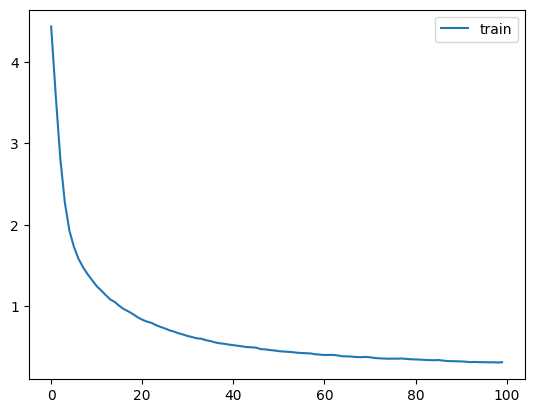

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9429 - loss: 0.4656  


Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_120 (Dense)               │ (None, 50)             │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 26)             │         1,326 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,776 (135.84 KB)

 Trainable params: 34,776 (135.84 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - categorical_accuracy: 0.0849 - loss: 4.6878  
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.2902 - loss: 3.9079 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.4861 - loss: 3.1902 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.6569 - loss: 2.6344 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.7225 - loss: 2.1696 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.8113 - loss: 1.8837 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.8661 - loss: 1.6595 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.8912 - loss: 1.5248 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9214 - loss: 1.4107 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9265 - loss: 1.3287 
Epoch 11/100
11/11

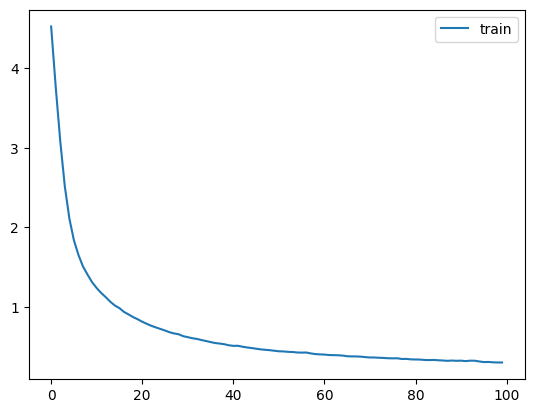

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9295 - loss: 0.5266  


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_123 (Dense)               │ (None, 50)             │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_124 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_125 (Dense)               │ (None, 26)             │         1,326 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,776 (135.84 KB)

 Trainable params: 34,776 (135.84 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - categorical_accuracy: 0.0600 - loss: 4.6571
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.2591 - loss: 3.9024 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.4549 - loss: 3.2163 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.6546 - loss: 2.5806 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.7404 - loss: 2.1835 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.8309 - loss: 1.9049 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.8750 - loss: 1.6731 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9176 - loss: 1.5225 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9223 - loss: 1.4164 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9559 - loss: 1.3082 
Epoch 11/100
11/11 ━

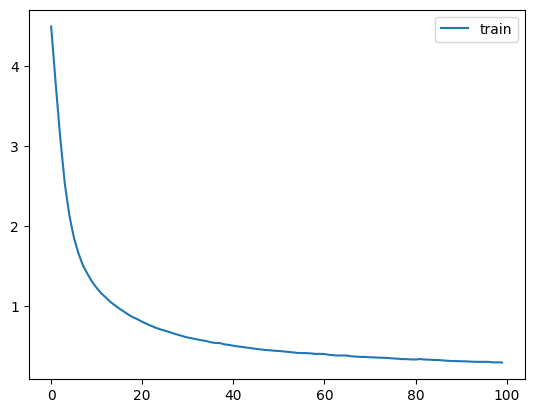

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9240 - loss: 0.5202  
Accuracy para 3 splits: 0.9397435983022054


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_126 (Dense)               │ (None, 50)             │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_127 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 26)             │         1,326 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,776 (135.84 KB)

 Trainable params: 34,776 (135.84 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - categorical_accuracy: 0.1344 - loss: 4.5255
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.3975 - loss: 3.5556 
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.6469 - loss: 2.6572 
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.7748 - loss: 2.1275 
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.8732 - loss: 1.7844 
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.8952 - loss: 1.5991 
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9115 - loss: 1.4660 
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9368 - loss: 1.3556 
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9498 - loss: 1.2690 
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9435 - loss: 1.2051 
Epoch 11/100
13/13 ━

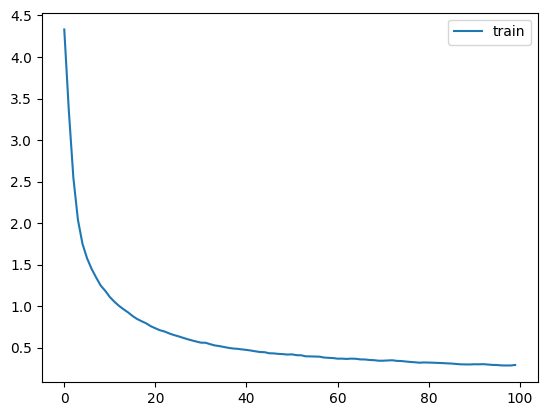

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9213 - loss: 0.4717  


Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_129 (Dense)               │ (None, 50)             │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_130 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_131 (Dense)               │ (None, 26)             │         1,326 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,776 (135.84 KB)

 Trainable params: 34,776 (135.84 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - categorical_accuracy: 0.0692 - loss: 4.6375
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.3033 - loss: 3.7709 
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.5132 - loss: 3.0163 
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.7070 - loss: 2.4065 
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.8263 - loss: 1.9679 
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.8795 - loss: 1.7110 
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9013 - loss: 1.5645 
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9208 - loss: 1.3973 
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9410 - loss: 1.3144 
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9556 - loss: 1.1915 
Epoch 11/100
13/13 ━

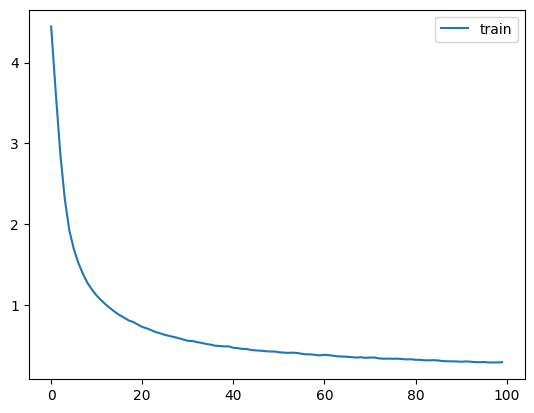

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.9440 - loss: 0.4515  


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_132 (Dense)               │ (None, 50)             │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 26)             │         1,326 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,776 (135.84 KB)

 Trainable params: 34,776 (135.84 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_accuracy: 0.0708 - loss: 4.6902   
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.3217 - loss: 3.7269 
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.5055 - loss: 2.9002 
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.7307 - loss: 2.2660 
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.8127 - loss: 1.9153 
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.8769 - loss: 1.6906 
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9129 - loss: 1.5345 
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9060 - loss: 1.4333 
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9485 - loss: 1.3220 
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9619 - loss: 1.2465 
Epoch 11/100
13/1

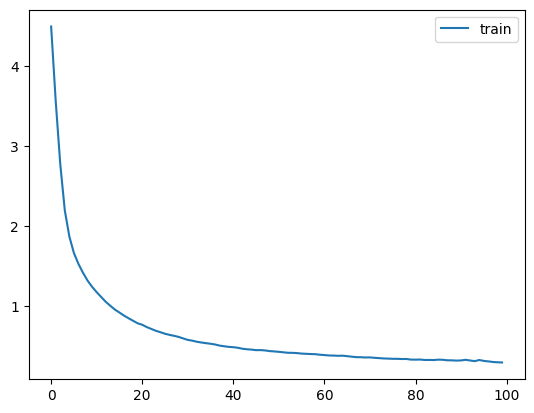

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9491 - loss: 0.4472  


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_135 (Dense)               │ (None, 50)             │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 26)             │         1,326 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,776 (135.84 KB)

 Trainable params: 34,776 (135.84 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_accuracy: 0.0776 - loss: 4.7665  
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.2686 - loss: 3.9253 
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.4730 - loss: 3.1588 
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.7088 - loss: 2.4173 
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.8478 - loss: 1.9304 
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9039 - loss: 1.6452 
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9121 - loss: 1.4844 
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9268 - loss: 1.3566 
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9235 - loss: 1.2771 
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9461 - loss: 1.1796 
Epoch 11/100
13/13

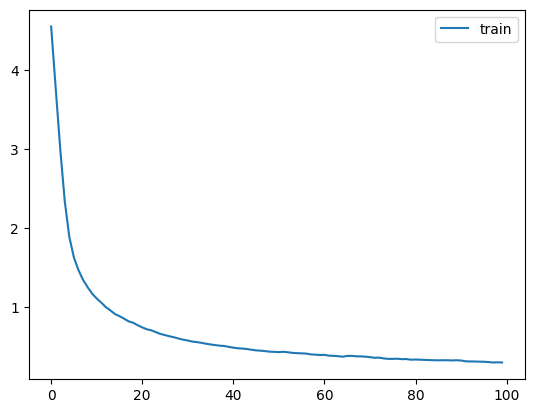

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9384 - loss: 0.5014  


Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_138 (Dense)               │ (None, 50)             │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_139 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_140 (Dense)               │ (None, 26)             │         1,326 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,776 (135.84 KB)

 Trainable params: 34,776 (135.84 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_accuracy: 0.0888 - loss: 4.5591       
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.3329 - loss: 3.7125 
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.5525 - loss: 2.9347 
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.7486 - loss: 2.2251 
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.8291 - loss: 1.8314 
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.8754 - loss: 1.5879 
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9114 - loss: 1.4490 
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9188 - loss: 1.3310 
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9543 - loss: 1.2347 
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9480 - loss: 1.1689 
Epoch 11/100


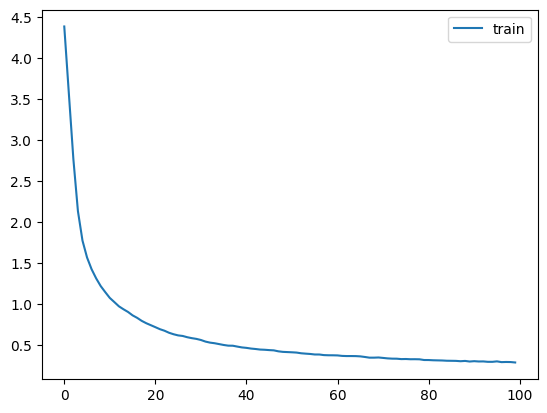

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9345 - loss: 0.4431  
Accuracy para 5 splits: 0.9384615421295166


Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_141 (Dense)               │ (None, 50)             │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 26)             │         1,326 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,776 (135.84 KB)

 Trainable params: 34,776 (135.84 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - categorical_accuracy: 0.0863 - loss: 4.5821
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.3211 - loss: 3.6330 
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.6036 - loss: 2.8382 
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.7090 - loss: 2.2270 
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.7752 - loss: 1.9235 
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.8371 - loss: 1.6968 
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.8798 - loss: 1.5312 
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.8981 - loss: 1.4252 
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9059 - loss: 1.3418 
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9352 - loss: 1.2568 
Epoch 11/100
15/15 ━

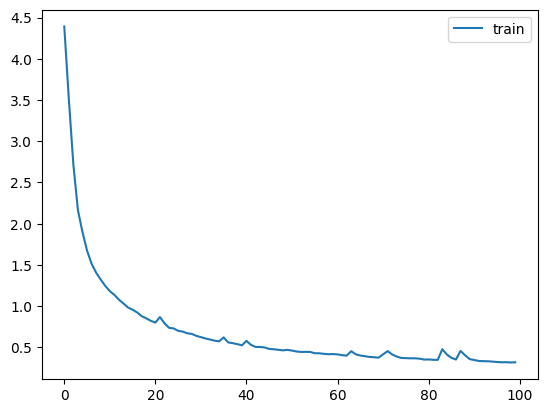

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9715 - loss: 0.4364  


Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_144 (Dense)               │ (None, 50)             │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_145 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_146 (Dense)               │ (None, 26)             │         1,326 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,776 (135.84 KB)

 Trainable params: 34,776 (135.84 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - categorical_accuracy: 0.0997 - loss: 4.5583
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.4313 - loss: 3.5837 
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.5866 - loss: 2.8609 
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.7608 - loss: 2.2523 
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.8279 - loss: 1.8936 
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.8734 - loss: 1.6722 
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.8892 - loss: 1.5247 
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.8994 - loss: 1.4282 
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9173 - loss: 1.3346 
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9301 - loss: 1.2631 
Epoch 11/100
15/15 ━

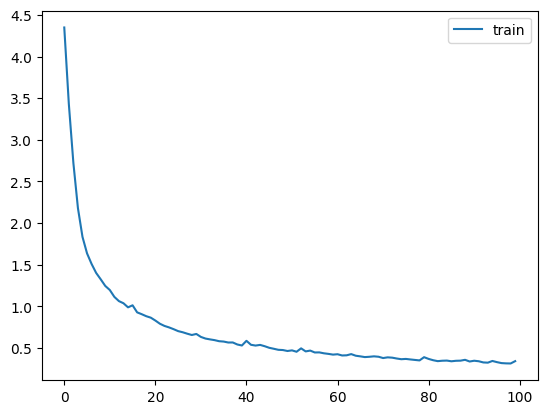

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9400 - loss: 0.4714  


Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_147 (Dense)               │ (None, 50)             │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_148 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 26)             │         1,326 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,776 (135.84 KB)

 Trainable params: 34,776 (135.84 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - categorical_accuracy: 0.0833 - loss: 4.6632
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.3712 - loss: 3.6340 
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.5078 - loss: 2.9026 
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.6751 - loss: 2.2976 
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.7662 - loss: 1.9364 
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.8219 - loss: 1.7089 
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.8537 - loss: 1.5729 
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.8952 - loss: 1.4539 
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9176 - loss: 1.3278 
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9229 - loss: 1.2654 
Epoch 11/100
15/15 ━

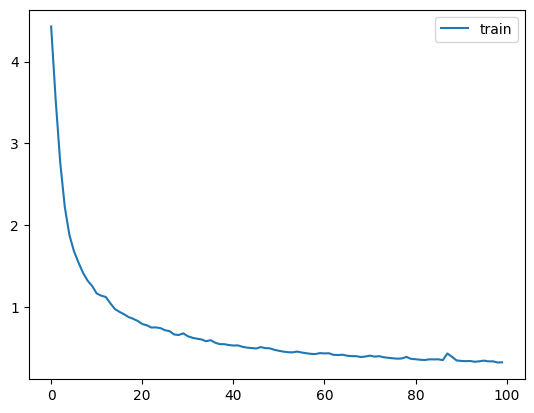

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9217 - loss: 0.5557  


Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_150 (Dense)               │ (None, 50)             │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_152 (Dense)               │ (None, 26)             │         1,326 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,776 (135.84 KB)

 Trainable params: 34,776 (135.84 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - categorical_accuracy: 0.1164 - loss: 4.4606
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.4332 - loss: 3.3892 
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.6449 - loss: 2.5970 
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.7175 - loss: 2.1316 
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.8235 - loss: 1.8387 
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.8332 - loss: 1.6887 
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9000 - loss: 1.4991 
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.8970 - loss: 1.4309 
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9197 - loss: 1.3473 
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9325 - loss: 1.2542 
Epoch 11/100
15/15 ━

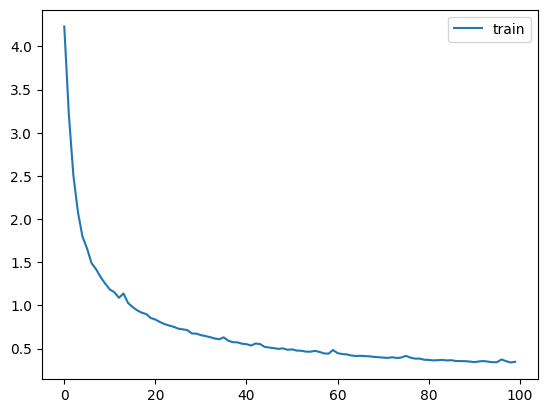

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.8942 - loss: 0.5851  


Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_153 (Dense)               │ (None, 50)             │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_154 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_155 (Dense)               │ (None, 26)             │         1,326 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,776 (135.84 KB)

 Trainable params: 34,776 (135.84 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - categorical_accuracy: 0.1107 - loss: 4.5504
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.3031 - loss: 3.7763 
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.5270 - loss: 2.9901 
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.6974 - loss: 2.3154 
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.8088 - loss: 1.8755 
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.8623 - loss: 1.6259 
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.8920 - loss: 1.4668 
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9112 - loss: 1.3646 
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9230 - loss: 1.2804 
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9331 - loss: 1.2166 
Epoch 11/100
15/15 ━

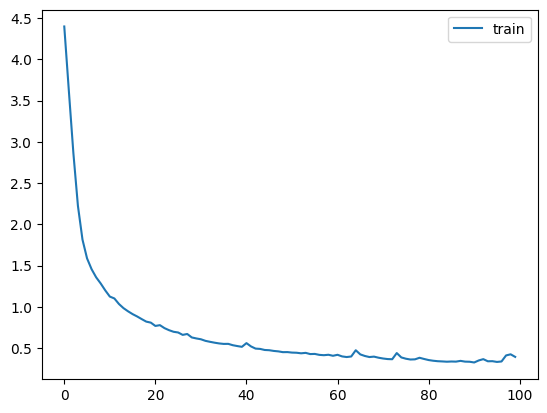

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9435 - loss: 0.5707  


Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_156 (Dense)               │ (None, 50)             │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_157 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_158 (Dense)               │ (None, 26)             │         1,326 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,776 (135.84 KB)

 Trainable params: 34,776 (135.84 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_accuracy: 0.0729 - loss: 4.6663   
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.3243 - loss: 3.7879 
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.5218 - loss: 2.9604 
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.6817 - loss: 2.3690 
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.7453 - loss: 1.9940 
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.7932 - loss: 1.7762 
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.8476 - loss: 1.5612 
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.8932 - loss: 1.4441 
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9367 - loss: 1.3237 
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9040 - loss: 1.2573 
Epoch 11/100
15/1

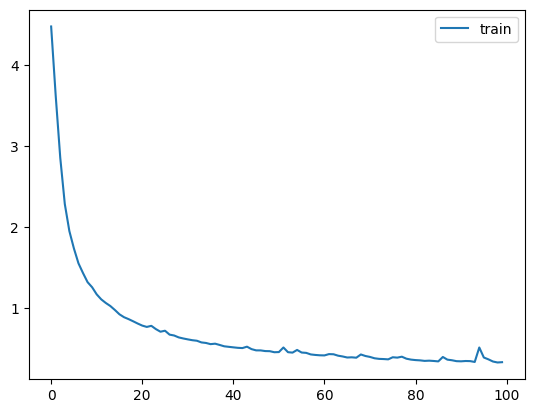

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9270 - loss: 0.4678  


Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_159 (Dense)               │ (None, 50)             │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_160 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_161 (Dense)               │ (None, 26)             │         1,326 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,776 (135.84 KB)

 Trainable params: 34,776 (135.84 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - categorical_accuracy: 0.0654 - loss: 4.7046   
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.2548 - loss: 3.9697
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.4265 - loss: 3.2636 
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.6285 - loss: 2.5949 
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.7285 - loss: 2.1229 
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.7747 - loss: 1.8424 
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.8485 - loss: 1.6458 
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.8842 - loss: 1.4989 
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.8924 - loss: 1.3780 
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9142 - loss: 1.3025 
Epoch 11/100
15/15

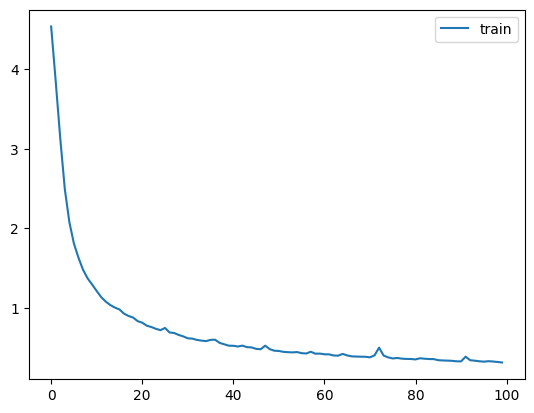

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9451 - loss: 0.4417  


Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_162 (Dense)               │ (None, 50)             │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_163 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_164 (Dense)               │ (None, 26)             │         1,326 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,776 (135.84 KB)

 Trainable params: 34,776 (135.84 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - categorical_accuracy: 0.0961 - loss: 4.5519
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.4079 - loss: 3.5417
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.6196 - loss: 2.7173 
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.7242 - loss: 2.2389 
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.7714 - loss: 1.9862 
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.8569 - loss: 1.7292 
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9092 - loss: 1.5770 
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9110 - loss: 1.4741 
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9155 - loss: 1.4039 
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9217 - loss: 1.3129 
Epoch 11/100
15/15 ━━

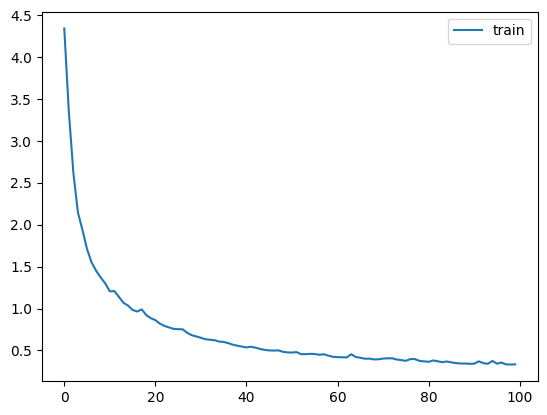

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9654 - loss: 0.4779  


Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_165 (Dense)               │ (None, 50)             │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_166 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_167 (Dense)               │ (None, 26)             │         1,326 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,776 (135.84 KB)

 Trainable params: 34,776 (135.84 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - categorical_accuracy: 0.0991 - loss: 4.5302
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.4111 - loss: 3.5762 
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.5853 - loss: 2.7660 
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.7279 - loss: 2.2240 
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.8104 - loss: 1.9128 
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.8400 - loss: 1.6855
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.8900 - loss: 1.5361 
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9097 - loss: 1.4370
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.9089 - loss: 1.3775
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9228 - loss: 1.2852 
Epoch 11/100
15/15 ━━━━

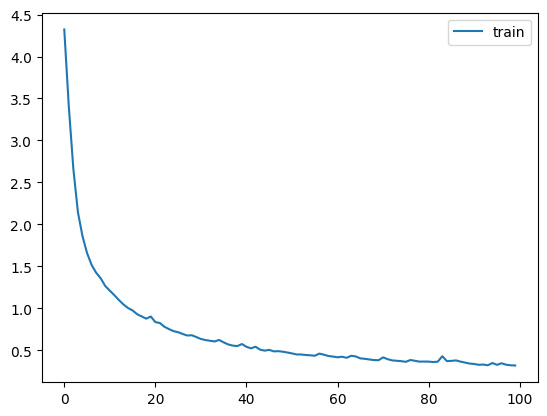

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9629 - loss: 0.4271  


Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_168 (Dense)               │ (None, 50)             │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_169 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_170 (Dense)               │ (None, 26)             │         1,326 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,776 (135.84 KB)

 Trainable params: 34,776 (135.84 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_accuracy: 0.0767 - loss: 4.6226   
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.3211 - loss: 3.7222 
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.5070 - loss: 3.0351 
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.6504 - loss: 2.3875 
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.8101 - loss: 1.8957 
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.8260 - loss: 1.6732 
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.8834 - loss: 1.4535 
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9059 - loss: 1.3164 
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.9034 - loss: 1.2442
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9116 - loss: 1.1976 
Epoch 11/100
15/15

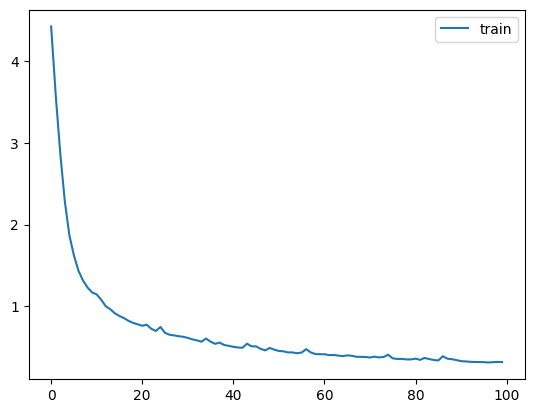

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9412 - loss: 0.5279  
Accuracy para 10 splits: 0.9442307651042938
Resultados:
Splits	Accuracy
3	0.9397435983022054
5	0.9384615421295166
10	0.9442307651042938


In [22]:
# Entrenamos el modelo simple
num_epochs = 100
batch_size = 100


# Hacemos k-fold cross validation
n_splits = [3,5,10]
accuracy_split = []
for n in n_splits:
    kf = KFold(n_splits=n, shuffle=True)

    accuracy = []

    for train_index, test_index in kf.split(data):
        data_train, data_test = data[train_index], data[test_index]
        label_train, label_test = label[train_index], label[test_index]
        norm = Normalize()
        norm.fit(data_train)
        data_norm = norm.transform(data_train)
        data_test = norm.transform(data_test)



        fn_perdida = keras.losses.CategoricalCrossentropy() # Función de pérdida
        optimizador = keras.optimizers.Adam(0.001) # Optimizador Adam con learning rate de 0.001
        metrica = keras.metrics.CategoricalAccuracy() # Métrica de evaluación

        modelo = crear_red(data_norm, capas = 2, neuronas = 50)
        modelo.compile(optimizer=optimizador, loss=fn_perdida, metrics=[metrica])
        history = modelo.fit(data_norm, label_train, epochs=num_epochs, batch_size=batch_size)

        # Mostramos la evolución de la función de pérdida
        pyplot.plot(history.history['loss'], label='train')
        pyplot.legend()
        pyplot.show()

        # Evaluamos el modelo
        result = modelo.evaluate(data_test, label_test)
        accuracy.append(result[1])

    print(f'Accuracy para {n} splits: {np.mean(accuracy)}')
    accuracy_split.append(np.mean(accuracy))

# Mostramos los resultados en una tabla
print('Resultados:')
print('Splits\tAccuracy')
for i in range(len(n_splits)):
    print(f'{n_splits[i]}\t{accuracy_split[i]}')


c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_171 (Dense)               │ (None, 10)             │         6,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_172 (Dense)               │ (None, 26)             │           286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,466 (25.26 KB)

 Trainable params: 6,466 (25.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_accuracy: 0.0271 - loss: 3.5557  
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.0991 - loss: 3.1272 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.1431 - loss: 3.0099 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.1580 - loss: 2.8735 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.1933 - loss: 2.7234 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.2266 - loss: 2.5621 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.2803 - loss: 2.4628 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.2924 - loss: 2.3352 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.2958 - loss: 2.2564 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.3220 - loss: 2.2037 
Epoch 11/100
11/11

Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_173 (Dense)               │ (None, 10)             │         6,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_174 (Dense)               │ (None, 26)             │           286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,466 (25.26 KB)

 Trainable params: 6,466 (25.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - categorical_accuracy: 0.0660 - loss: 3.3232
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.1455 - loss: 2.9971  
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.1769 - loss: 2.8645 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.2265 - loss: 2.7333 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.2851 - loss: 2.5657
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.2834 - loss: 2.5158  
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.3109 - loss: 2.3391 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.3383 - loss: 2.2268 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.3840 - loss: 2.1014 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.3960 - loss: 1.9998 
Epoch 11/100
11/11 

Model: "sequential_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_175 (Dense)               │ (None, 10)             │         6,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_176 (Dense)               │ (None, 26)             │           286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,466 (25.26 KB)

 Trainable params: 6,466 (25.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - categorical_accuracy: 0.0678 - loss: 3.3099
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0983 - loss: 2.9717 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.1330 - loss: 2.8047 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.2051 - loss: 2.6488 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.2552 - loss: 2.5071 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.3111 - loss: 2.3657 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.3675 - loss: 2.1961 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.3900 - loss: 1.9975 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.4297 - loss: 1.8404 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.5126 - loss: 1.6421 
Epoch 11/100
11/11 ━

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


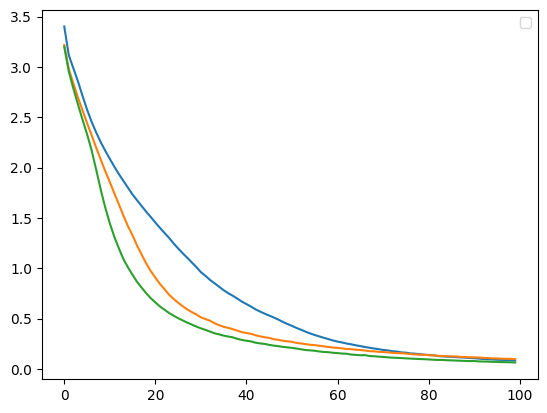

activation: relu, regularization: 0.0001, hidden_layer_elements: 10, n_hidden_layers: 1
Accuracy test: 0.9051282008488973
Accuracy train: 0.9955128232638041


Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_177 (Dense)               │ (None, 10)             │         6,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_178 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_179 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_180 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_181 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_182 (Dense)               │ (None, 26)             │           286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,906 (26.98 KB)

 Trainable params: 6,906 (26.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - categorical_accuracy: 0.0661 - loss: 3.2803
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0538 - loss: 3.2110 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0508 - loss: 3.1469 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0945 - loss: 2.9968 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0824 - loss: 2.9103 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.1071 - loss: 2.8006 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.1313 - loss: 2.7439 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.1702 - loss: 2.6250 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.2102 - loss: 2.5403 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.2557 - loss: 2.4149 
Epoch 11/100
11/11 ━

Model: "sequential_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_183 (Dense)               │ (None, 10)             │         6,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_184 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_185 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_186 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_187 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_188 (Dense)               │ (None, 26)             │           286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,906 (26.98 KB)

 Trainable params: 6,906 (26.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - categorical_accuracy: 0.0537 - loss: 3.3420
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0550 - loss: 3.2243 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.0627 - loss: 3.1833 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.0706 - loss: 3.1416 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.0856 - loss: 3.0884 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.0798 - loss: 3.0223  
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0658 - loss: 2.9886 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0692 - loss: 2.9061 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0786 - loss: 2.8337 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0849 - loss: 2.7586 
Epoch 11/100
11/11 

Model: "sequential_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_189 (Dense)               │ (None, 10)             │         6,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_190 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_191 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_192 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_193 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_194 (Dense)               │ (None, 26)             │           286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,906 (26.98 KB)

 Trainable params: 6,906 (26.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - categorical_accuracy: 0.0421 - loss: 3.2447
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0420 - loss: 3.1843 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0800 - loss: 3.1163 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0815 - loss: 3.0553 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0717 - loss: 2.9925 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.1124 - loss: 2.8695 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.1148 - loss: 2.8280 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.1333 - loss: 2.7323 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.1401 - loss: 2.6560 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.1599 - loss: 2.5425 
Epoch 11/100
11/11 ━

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


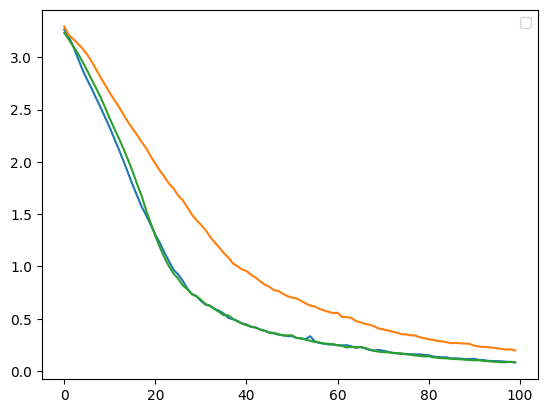

activation: relu, regularization: 0.0001, hidden_layer_elements: 10, n_hidden_layers: 5
Accuracy test: 0.7737179597218832
Accuracy train: 0.9817307790120443


Model: "sequential_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_195 (Dense)               │ (None, 100)            │        61,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_196 (Dense)               │ (None, 26)             │         2,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,426 (251.66 KB)

 Trainable params: 64,426 (251.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - categorical_accuracy: 0.1453 - loss: 3.2770
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.5518 - loss: 1.7428 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.7747 - loss: 1.0230 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.8587 - loss: 0.6651 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.8966 - loss: 0.4894 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9380 - loss: 0.3772 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9420 - loss: 0.3191 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9575 - loss: 0.2445 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9696 - loss: 0.2172 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9763 - loss: 0.2037 
Epoch 11/100
11/11 ━

Model: "sequential_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_197 (Dense)               │ (None, 100)            │        61,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_198 (Dense)               │ (None, 26)             │         2,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,426 (251.66 KB)

 Trainable params: 64,426 (251.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - categorical_accuracy: 0.1386 - loss: 3.1319
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.5696 - loss: 1.6879  
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.7704 - loss: 0.9769 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.8893 - loss: 0.5905 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9363 - loss: 0.4229 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.9435 - loss: 0.3521 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9578 - loss: 0.2786 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9700 - loss: 0.2217 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9799 - loss: 0.1871 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9793 - loss: 0.1671 
Epoch 11/100
11/11 

Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_199 (Dense)               │ (None, 100)            │        61,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_200 (Dense)               │ (None, 26)             │         2,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,426 (251.66 KB)

 Trainable params: 64,426 (251.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - categorical_accuracy: 0.1607 - loss: 3.0936
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.5734 - loss: 1.6973  
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.7506 - loss: 1.0157 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.8455 - loss: 0.6499 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.8811 - loss: 0.4967 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9335 - loss: 0.3510 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9545 - loss: 0.3069 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9605 - loss: 0.2371 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9753 - loss: 0.1998 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9829 - loss: 0.1651 
Epoch 11/100
11/11 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


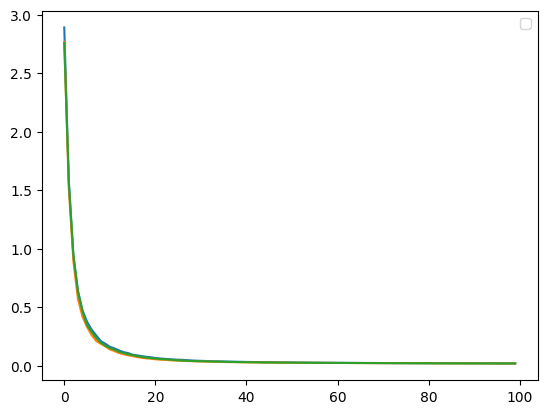

activation: relu, regularization: 0.0001, hidden_layer_elements: 100, n_hidden_layers: 1
Accuracy test: 0.9551282127698263
Accuracy train: 1.0


Model: "sequential_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_201 (Dense)               │ (None, 100)            │        61,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_202 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_203 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_204 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_205 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_206 (Dense)               │ (None, 26)             │         2,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,826 (409.48 KB)

 Trainable params: 104,826 (409.48 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - categorical_accuracy: 0.0878 - loss: 3.2136
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.3233 - loss: 2.4301
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.5275 - loss: 1.4529
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.6862 - loss: 0.9217
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.8080 - loss: 0.6396
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.8543 - loss: 0.4793
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - categorical_accuracy: 0.9032 - loss: 0.3738
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.9385 - loss: 0.2849
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.9232 - loss: 0.2729
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - categorical_accuracy: 0.9530 - loss: 0.2194
Epoch 11/100
11/11 ━━━━━━━━━━

Model: "sequential_67"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_207 (Dense)               │ (None, 100)            │        61,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_208 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_209 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_210 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_211 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_212 (Dense)               │ (None, 26)             │         2,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,826 (409.48 KB)

 Trainable params: 104,826 (409.48 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - categorical_accuracy: 0.1102 - loss: 3.1905
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.3104 - loss: 2.3172 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.6113 - loss: 1.3187
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.7120 - loss: 0.8401
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.7907 - loss: 0.6068
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.8786 - loss: 0.4332 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.9210 - loss: 0.3251
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.9299 - loss: 0.2903
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.9313 - loss: 0.2520
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.9645 - loss: 0.1881
Epoch 11/100
11/11 ━━━━━━━━

Model: "sequential_68"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_213 (Dense)               │ (None, 100)            │        61,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_214 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_215 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_216 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_217 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_218 (Dense)               │ (None, 26)             │         2,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,826 (409.48 KB)

 Trainable params: 104,826 (409.48 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - categorical_accuracy: 0.1109 - loss: 3.2111
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.4077 - loss: 2.2830 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.6786 - loss: 1.1541
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.7842 - loss: 0.7377
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.8641 - loss: 0.5145 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.8579 - loss: 0.4563 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.9005 - loss: 0.3586
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.9278 - loss: 0.2951
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.9541 - loss: 0.2317 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.9723 - loss: 0.1708 
Epoch 11/100
11/11 ━━━━━

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


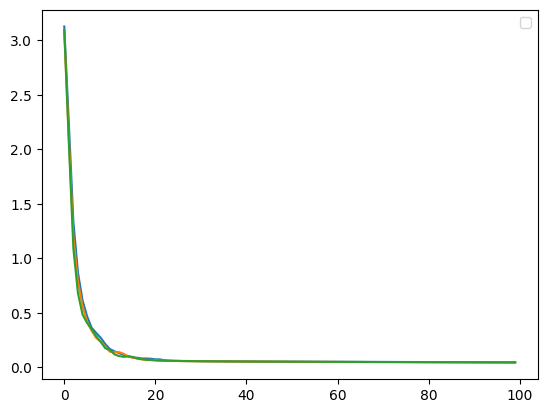

activation: relu, regularization: 0.0001, hidden_layer_elements: 100, n_hidden_layers: 5
Accuracy test: 0.9352564016977946
Accuracy train: 1.0


Model: "sequential_69"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_219 (Dense)               │ (None, 10)             │         6,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_220 (Dense)               │ (None, 26)             │           286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,466 (25.26 KB)

 Trainable params: 6,466 (25.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - categorical_accuracy: 0.0446 - loss: 5.1999
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.1079 - loss: 4.6457 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.1426 - loss: 4.2012 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.1644 - loss: 3.7854 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.2414 - loss: 3.4809 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.2966 - loss: 3.1710 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.3857 - loss: 2.9314 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.3960 - loss: 2.7496 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.4674 - loss: 2.5560 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.4848 - loss: 2.3918 
Epoch 11/100
11/11 ━

Model: "sequential_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_221 (Dense)               │ (None, 10)             │         6,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_222 (Dense)               │ (None, 26)             │           286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,466 (25.26 KB)

 Trainable params: 6,466 (25.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - categorical_accuracy: 0.0712 - loss: 5.2999
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.1508 - loss: 4.6232 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.1569 - loss: 4.1819 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.2034 - loss: 3.8008 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.2975 - loss: 3.5035 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.3612 - loss: 3.1911 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.4453 - loss: 2.9843 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.4966 - loss: 2.7682 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.5097 - loss: 2.5753 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.5968 - loss: 2.3774 
Epoch 11/100
11/11 ━

Model: "sequential_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_223 (Dense)               │ (None, 10)             │         6,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_224 (Dense)               │ (None, 26)             │           286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,466 (25.26 KB)

 Trainable params: 6,466 (25.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - categorical_accuracy: 0.0617 - loss: 5.1143
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0782 - loss: 4.5774 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.1574 - loss: 4.0639 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.1957 - loss: 3.6599 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.2725 - loss: 3.2806 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.3043 - loss: 3.0165 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.3841 - loss: 2.7502 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.4512 - loss: 2.5414 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.5142 - loss: 2.3348 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.5945 - loss: 2.1716 
Epoch 11/100
11/11 ━

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


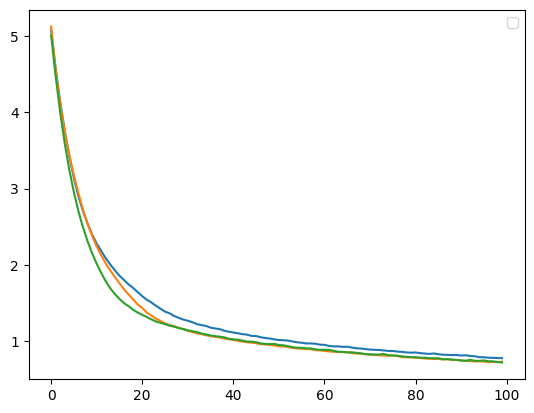

activation: relu, regularization: 0.1, hidden_layer_elements: 10, n_hidden_layers: 1
Accuracy test: 0.8948717912038168
Accuracy train: 0.9538461565971375


Model: "sequential_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_225 (Dense)               │ (None, 10)             │         6,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_226 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_227 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_228 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_229 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_230 (Dense)               │ (None, 26)             │           286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,906 (26.98 KB)

 Trainable params: 6,906 (26.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - categorical_accuracy: 0.0222 - loss: 9.0493
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0294 - loss: 8.2774 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0387 - loss: 7.6348 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.0489 - loss: 7.1193 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.0577 - loss: 6.7100 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.0568 - loss: 6.3777  
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0577 - loss: 6.0917 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0968 - loss: 5.8378 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0878 - loss: 5.6219 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0852 - loss: 5.4376 
Epoch 11/100
11/11 

Model: "sequential_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_231 (Dense)               │ (None, 10)             │         6,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_232 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_233 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_234 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_235 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_236 (Dense)               │ (None, 26)             │           286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,906 (26.98 KB)

 Trainable params: 6,906 (26.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - categorical_accuracy: 0.0382 - loss: 8.9572
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0491 - loss: 8.1835 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0469 - loss: 7.5542 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0625 - loss: 7.0480 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0511 - loss: 6.6450 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0446 - loss: 6.3209 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.0479 - loss: 6.0509 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0468 - loss: 5.8294 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.0457 - loss: 5.6338 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.0403 - loss: 5.4687 
Epoch 11/100
11/11 ━

Model: "sequential_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_237 (Dense)               │ (None, 10)             │         6,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_238 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_239 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_240 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_241 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_242 (Dense)               │ (None, 26)             │           286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,906 (26.98 KB)

 Trainable params: 6,906 (26.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - categorical_accuracy: 0.0507 - loss: 9.0615
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0412 - loss: 8.2802 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0518 - loss: 7.6323 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0673 - loss: 7.1190 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0819 - loss: 6.7117 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0785 - loss: 6.3740 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0843 - loss: 6.0972 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0696 - loss: 5.8477 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0813 - loss: 5.6580 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.0833 - loss: 5.4670 
Epoch 11/100
11/11 ━

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


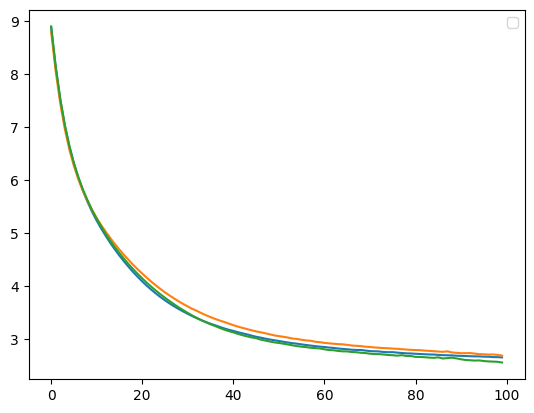

activation: relu, regularization: 0.1, hidden_layer_elements: 10, n_hidden_layers: 5
Accuracy test: 0.23012820879618326
Accuracy train: 0.29519230624039966


Model: "sequential_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_243 (Dense)               │ (None, 100)            │        61,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_244 (Dense)               │ (None, 26)             │         2,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,426 (251.66 KB)

 Trainable params: 64,426 (251.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - categorical_accuracy: 0.1386 - loss: 19.4677
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.4243 - loss: 14.4239 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.6852 - loss: 10.5437 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.8091 - loss: 7.7358 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.8552 - loss: 5.6471 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.8753 - loss: 4.2274  
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9083 - loss: 3.1659 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9177 - loss: 2.4571 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9404 - loss: 1.9641 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9372 - loss: 1.5968 
Epoch 11/100
11/

Model: "sequential_76"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_245 (Dense)               │ (None, 100)            │        61,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_246 (Dense)               │ (None, 26)             │         2,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,426 (251.66 KB)

 Trainable params: 64,426 (251.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - categorical_accuracy: 0.0936 - loss: 19.8414
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.4758 - loss: 14.7894 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.7127 - loss: 11.0145 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.8439 - loss: 8.0781 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.8861 - loss: 5.9549 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9101 - loss: 4.4518 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9333 - loss: 3.3476 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9268 - loss: 2.5857 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9606 - loss: 2.0212 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.9516 - loss: 1.6508 
Epoch 11/100
11/1

Model: "sequential_77"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_247 (Dense)               │ (None, 100)            │        61,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_248 (Dense)               │ (None, 26)             │         2,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,426 (251.66 KB)

 Trainable params: 64,426 (251.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - categorical_accuracy: 0.1130 - loss: 19.7898
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.4419 - loss: 14.8157 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.7109 - loss: 11.1049 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.8279 - loss: 8.3013 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.8758 - loss: 6.2218 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9172 - loss: 4.6907 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9228 - loss: 3.5704 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9242 - loss: 2.7817 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9462 - loss: 2.2194 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9478 - loss: 1.8176 
Epoch 11/100
11/1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


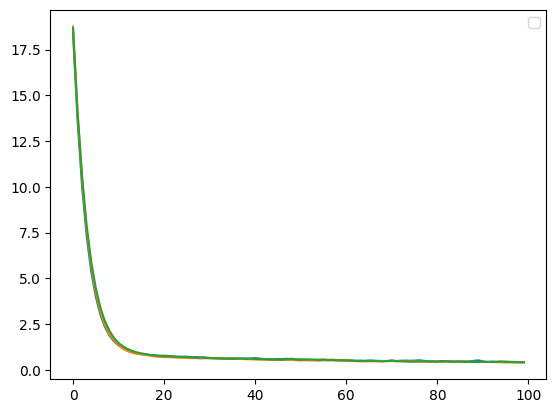

activation: relu, regularization: 0.1, hidden_layer_elements: 100, n_hidden_layers: 1
Accuracy test: 0.9217948714892069
Accuracy train: 0.9791666666666666


Model: "sequential_78"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_249 (Dense)               │ (None, 100)            │        61,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_250 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_251 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_252 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_253 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_254 (Dense)               │ (None, 26)             │         2,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,826 (409.48 KB)

 Trainable params: 104,826 (409.48 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - categorical_accuracy: 0.0620 - loss: 57.3758
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.1610 - loss: 45.4789
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.1922 - loss: 35.9395
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.2248 - loss: 28.4738 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - categorical_accuracy: 0.2868 - loss: 22.6802
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.3291 - loss: 18.2119
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.3164 - loss: 14.7460
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.3241 - loss: 12.0816
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.3956 - loss: 10.0145
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.4166 - loss: 8.4196 
Epoch 11/100
11/11

Model: "sequential_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_255 (Dense)               │ (None, 100)            │        61,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_256 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_257 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_258 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_259 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_260 (Dense)               │ (None, 26)             │         2,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,826 (409.48 KB)

 Trainable params: 104,826 (409.48 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - categorical_accuracy: 0.0563 - loss: 57.1467
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.1321 - loss: 45.2401 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.1491 - loss: 35.7017 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.1262 - loss: 28.2408
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - categorical_accuracy: 0.1306 - loss: 22.4543
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.1325 - loss: 17.9735
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.2025 - loss: 14.5381
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.2241 - loss: 11.9202
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.2714 - loss: 9.8826
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.3197 - loss: 8.2972
Epoch 11/100
11/11 

Model: "sequential_80"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_261 (Dense)               │ (None, 100)            │        61,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_262 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_263 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_264 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_265 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_266 (Dense)               │ (None, 26)             │         2,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,826 (409.48 KB)

 Trainable params: 104,826 (409.48 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - categorical_accuracy: 0.0758 - loss: 57.1974
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.1861 - loss: 45.3109 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.2131 - loss: 35.7814
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.2027 - loss: 28.3212
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.2508 - loss: 22.5589
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.2307 - loss: 18.1370
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - categorical_accuracy: 0.2446 - loss: 14.7051
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.2544 - loss: 12.0531
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.3066 - loss: 9.9537  
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.3636 - loss: 8.2946
Epoch 11/100
11/11

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


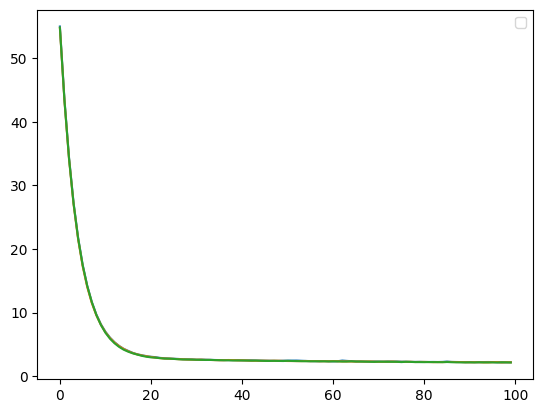

activation: relu, regularization: 0.1, hidden_layer_elements: 100, n_hidden_layers: 5
Accuracy test: 0.549358973900477
Accuracy train: 0.6269230842590332


Model: "sequential_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_267 (Dense)               │ (None, 10)             │         6,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_268 (Dense)               │ (None, 26)             │           286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,466 (25.26 KB)

 Trainable params: 6,466 (25.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - categorical_accuracy: 0.0460 - loss: 3.4865  
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - categorical_accuracy: 0.1170 - loss: 3.0861
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.2185 - loss: 2.8284 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.3101 - loss: 2.6723 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - categorical_accuracy: 0.3732 - loss: 2.5603
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - categorical_accuracy: 0.4149 - loss: 2.4640
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.4886 - loss: 2.3594 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - categorical_accuracy: 0.5120 - loss: 2.2946
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - categorical_accuracy: 0.5440 - loss: 2.2392
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.5833 - loss: 2.1616 
Epoch 11/100


Model: "sequential_82"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_269 (Dense)               │ (None, 10)             │         6,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_270 (Dense)               │ (None, 26)             │           286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,466 (25.26 KB)

 Trainable params: 6,466 (25.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_accuracy: 0.0744 - loss: 3.1753  
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.1499 - loss: 2.8724 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.2613 - loss: 2.6949 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.3707 - loss: 2.5314 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.4272 - loss: 2.4453 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.4792 - loss: 2.3623 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.5283 - loss: 2.2615 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.5917 - loss: 2.1680 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.6119 - loss: 2.0977 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.7058 - loss: 1.9830 
Epoch 11/100
11/11

Model: "sequential_83"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_271 (Dense)               │ (None, 10)             │         6,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_272 (Dense)               │ (None, 26)             │           286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,466 (25.26 KB)

 Trainable params: 6,466 (25.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_accuracy: 0.0422 - loss: 3.2717  
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - categorical_accuracy: 0.0935 - loss: 2.9609
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.2008 - loss: 2.7719 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.2718 - loss: 2.6215 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.3504 - loss: 2.4913 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - categorical_accuracy: 0.4081 - loss: 2.3956
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - categorical_accuracy: 0.4762 - loss: 2.3164
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.5236 - loss: 2.2440 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.5402 - loss: 2.1772 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.5590 - loss: 2.1139 
Epoch 11/100
11

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


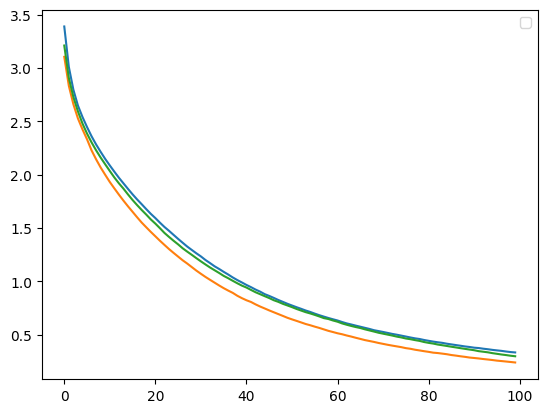

activation: tanh, regularization: 0.0001, hidden_layer_elements: 10, n_hidden_layers: 1
Accuracy test: 0.875
Accuracy train: 0.9823717872301737


Model: "sequential_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_273 (Dense)               │ (None, 10)             │         6,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_274 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_275 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_276 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_277 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_278 (Dense)               │ (None, 26)             │           286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,906 (26.98 KB)

 Trainable params: 6,906 (26.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - categorical_accuracy: 0.0637 - loss: 3.2663
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.1349 - loss: 3.1364 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.2071 - loss: 3.0560 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.2239 - loss: 2.9791 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.2344 - loss: 2.9136 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.2683 - loss: 2.8419 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.2996 - loss: 2.7599 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.2946 - loss: 2.6996 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.3443 - loss: 2.6039 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.3530 - loss: 2.5563 
Epoch 11/100
11/11 ━

Model: "sequential_85"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_279 (Dense)               │ (None, 10)             │         6,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_280 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_281 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_282 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_283 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_284 (Dense)               │ (None, 26)             │           286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,906 (26.98 KB)

 Trainable params: 6,906 (26.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - categorical_accuracy: 0.0778 - loss: 3.2342
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.1513 - loss: 3.1178 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.2001 - loss: 3.0380 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.2504 - loss: 2.9629 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.2665 - loss: 2.8852 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.3133 - loss: 2.7946 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.3150 - loss: 2.7106 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.3323 - loss: 2.6378 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.3438 - loss: 2.5545 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.3622 - loss: 2.4926 
Epoch 11/100
11/11 ━

Model: "sequential_86"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_285 (Dense)               │ (None, 10)             │         6,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_286 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_287 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_288 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_289 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_290 (Dense)               │ (None, 26)             │           286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,906 (26.98 KB)

 Trainable params: 6,906 (26.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - categorical_accuracy: 0.0693 - loss: 3.2292
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.1819 - loss: 3.0723 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.2301 - loss: 2.9874 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.2577 - loss: 2.8882 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.2493 - loss: 2.8043 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.2565 - loss: 2.7434 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.2861 - loss: 2.6590 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.3093 - loss: 2.5988 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.3244 - loss: 2.5460 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.3687 - loss: 2.4786 
Epoch 11/100
11/11 ━

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


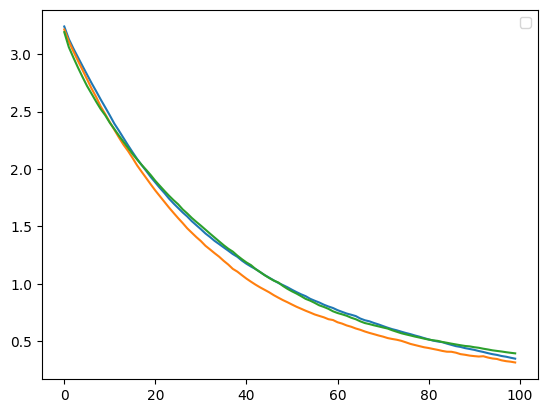

activation: tanh, regularization: 0.0001, hidden_layer_elements: 10, n_hidden_layers: 5
Accuracy test: 0.7653846144676208
Accuracy train: 0.9637820323308309


Model: "sequential_87"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_291 (Dense)               │ (None, 100)            │        61,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_292 (Dense)               │ (None, 26)             │         2,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,426 (251.66 KB)

 Trainable params: 64,426 (251.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_accuracy: 0.1144 - loss: 3.1955  
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.6053 - loss: 1.8005 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.7702 - loss: 1.2243 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.8466 - loss: 0.8960 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.8874 - loss: 0.7284 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.9397 - loss: 0.5614 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.9491 - loss: 0.4695 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.9525 - loss: 0.4017 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9712 - loss: 0.3351 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.9728 - loss: 0.2938 
Epoch 11/100
11/11

Model: "sequential_88"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_293 (Dense)               │ (None, 100)            │        61,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_294 (Dense)               │ (None, 26)             │         2,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,426 (251.66 KB)

 Trainable params: 64,426 (251.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_accuracy: 0.1679 - loss: 3.0316  
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.5925 - loss: 1.7197 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.7745 - loss: 1.1584 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.8379 - loss: 0.8733 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.8971 - loss: 0.6978 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9332 - loss: 0.5453 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9452 - loss: 0.4566 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.9781 - loss: 0.3654 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.9736 - loss: 0.3289 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9824 - loss: 0.2793 
Epoch 11/100
11/11

Model: "sequential_89"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_295 (Dense)               │ (None, 100)            │        61,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_296 (Dense)               │ (None, 26)             │         2,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,426 (251.66 KB)

 Trainable params: 64,426 (251.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_accuracy: 0.1486 - loss: 3.1442  
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.6388 - loss: 1.6821 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.8051 - loss: 1.1548 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.8839 - loss: 0.8219 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9154 - loss: 0.6589 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.9416 - loss: 0.5233 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9440 - loss: 0.4539 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.9542 - loss: 0.3692 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.9688 - loss: 0.3158 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9794 - loss: 0.2767 
Epoch 11/100
11/11

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


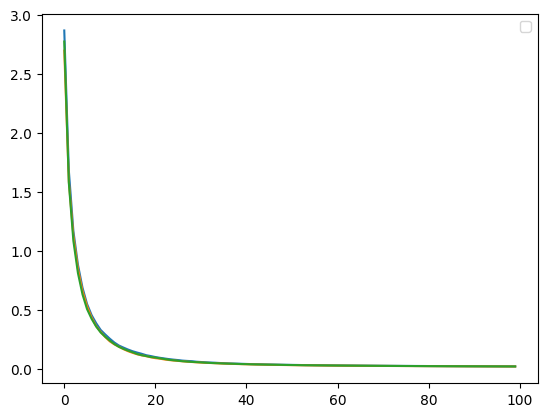

activation: tanh, regularization: 0.0001, hidden_layer_elements: 100, n_hidden_layers: 1
Accuracy test: 0.9564102490743002
Accuracy train: 1.0


Model: "sequential_90"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_297 (Dense)               │ (None, 100)            │        61,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_298 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_299 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_300 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_301 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_302 (Dense)               │ (None, 26)             │         2,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,826 (409.48 KB)

 Trainable params: 104,826 (409.48 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - categorical_accuracy: 0.1726 - loss: 3.0161    
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.5754 - loss: 1.8993 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.7812 - loss: 1.2811 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.8618 - loss: 0.8945 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.8950 - loss: 0.6690 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9336 - loss: 0.5008 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9557 - loss: 0.3745 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9781 - loss: 0.2823 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9833 - loss: 0.2473 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9848 - loss: 0.2173 
Epoch 11/100
11/

Model: "sequential_91"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_303 (Dense)               │ (None, 100)            │        61,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_304 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_305 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_306 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_307 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_308 (Dense)               │ (None, 26)             │         2,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,826 (409.48 KB)

 Trainable params: 104,826 (409.48 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - categorical_accuracy: 0.2098 - loss: 2.9577
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.6202 - loss: 1.8544 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.7876 - loss: 1.2438 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.8626 - loss: 0.8601 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9252 - loss: 0.6382 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9429 - loss: 0.4670 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9691 - loss: 0.3465 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9847 - loss: 0.2558 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9871 - loss: 0.2134 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9885 - loss: 0.1913 
Epoch 11/100
11/11 ━

Model: "sequential_92"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_309 (Dense)               │ (None, 100)            │        61,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_310 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_311 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_312 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_313 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_314 (Dense)               │ (None, 26)             │         2,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,826 (409.48 KB)

 Trainable params: 104,826 (409.48 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - categorical_accuracy: 0.1516 - loss: 3.1338
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.5910 - loss: 2.0265 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.7356 - loss: 1.3665 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.8479 - loss: 0.9709 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9054 - loss: 0.6642 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9570 - loss: 0.4685 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9668 - loss: 0.3393 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9711 - loss: 0.2859 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9884 - loss: 0.2160 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9932 - loss: 0.1799 
Epoch 11/100
11/11 ━

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


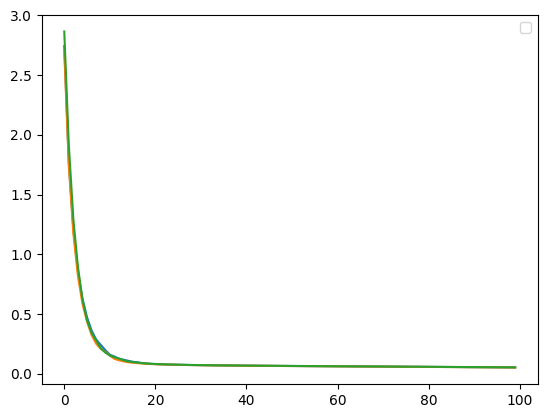

activation: tanh, regularization: 0.0001, hidden_layer_elements: 100, n_hidden_layers: 5
Accuracy test: 0.9525641004244486
Accuracy train: 1.0


Model: "sequential_93"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_315 (Dense)               │ (None, 10)             │         6,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_316 (Dense)               │ (None, 26)             │           286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,466 (25.26 KB)

 Trainable params: 6,466 (25.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - categorical_accuracy: 0.0805 - loss: 5.1383
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.1074 - loss: 4.5895 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.2496 - loss: 4.1030 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.3751 - loss: 3.7047 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.4754 - loss: 3.3799 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - categorical_accuracy: 0.5695 - loss: 3.1375
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.5669 - loss: 2.9551 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.6247 - loss: 2.7807 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.6437 - loss: 2.6445 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.6534 - loss: 2.5366 
Epoch 11/100
11/11

Model: "sequential_94"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_317 (Dense)               │ (None, 10)             │         6,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_318 (Dense)               │ (None, 26)             │           286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,466 (25.26 KB)

 Trainable params: 6,466 (25.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_accuracy: 0.0415 - loss: 5.1880  
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.1389 - loss: 4.5560 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.2100 - loss: 4.1292 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.2625 - loss: 3.7764 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.3067 - loss: 3.4711 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.3503 - loss: 3.2390 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.3491 - loss: 3.0359 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.4582 - loss: 2.8501 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.4727 - loss: 2.7018 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.5334 - loss: 2.5763 
Epoch 11/100
11/11

Model: "sequential_95"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_319 (Dense)               │ (None, 10)             │         6,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_320 (Dense)               │ (None, 26)             │           286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,466 (25.26 KB)

 Trainable params: 6,466 (25.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - categorical_accuracy: 0.0834 - loss: 5.1113  
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.1448 - loss: 4.5449 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.2207 - loss: 4.0482 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.2737 - loss: 3.7073 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.3621 - loss: 3.4028 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.4090 - loss: 3.1601 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.4885 - loss: 2.9551 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.4987 - loss: 2.8114 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.5807 - loss: 2.6585 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.5634 - loss: 2.5541 
Epoch 11/100
11/11

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


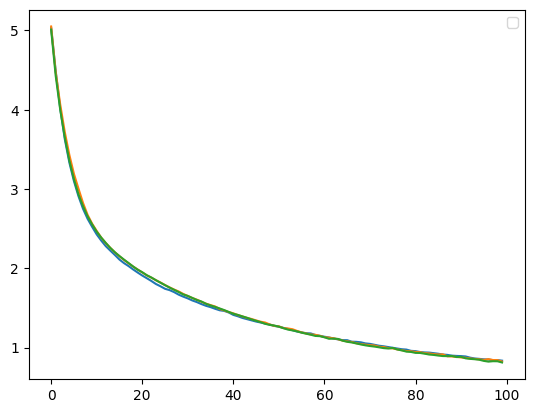

activation: tanh, regularization: 0.1, hidden_layer_elements: 10, n_hidden_layers: 1
Accuracy test: 0.8698718150456747
Accuracy train: 0.9442307750384012


Model: "sequential_96"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_321 (Dense)               │ (None, 10)             │         6,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_322 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_323 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_324 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_325 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_326 (Dense)               │ (None, 26)             │           286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,906 (26.98 KB)

 Trainable params: 6,906 (26.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - categorical_accuracy: 0.0551 - loss: 8.9347
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.0916 - loss: 8.1578 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.1358 - loss: 7.5217 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.1208 - loss: 7.0029 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.1351 - loss: 6.5770 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.1119 - loss: 6.2256 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.1305 - loss: 5.9322 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.1427 - loss: 5.6827 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.1422 - loss: 5.4654 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.1358 - loss: 5.2773 
Epoch 11/100
11/11 ━

Model: "sequential_97"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_327 (Dense)               │ (None, 10)             │         6,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_328 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_329 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_330 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_331 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_332 (Dense)               │ (None, 26)             │           286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,906 (26.98 KB)

 Trainable params: 6,906 (26.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - categorical_accuracy: 0.0615 - loss: 8.8654
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.1014 - loss: 8.1075 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.1127 - loss: 7.4775 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.1362 - loss: 6.9367 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.1635 - loss: 6.5045 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.1774 - loss: 6.1426 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.1795 - loss: 5.8411 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.2030 - loss: 5.5875 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.2202 - loss: 5.3778 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.1956 - loss: 5.2038 
Epoch 11/100
11/11 ━

Model: "sequential_98"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_333 (Dense)               │ (None, 10)             │         6,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_334 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_335 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_336 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_337 (Dense)               │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_338 (Dense)               │ (None, 26)             │           286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,906 (26.98 KB)

 Trainable params: 6,906 (26.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - categorical_accuracy: 0.0323 - loss: 9.1346
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.0800 - loss: 8.3339 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.1273 - loss: 7.6632 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.1283 - loss: 7.1430 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.1653 - loss: 6.7040 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.1745 - loss: 6.3404 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.1810 - loss: 6.0466 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.1971 - loss: 5.7932 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.1834 - loss: 5.5814 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.1859 - loss: 5.4003 
Epoch 11/100
11/11 ━

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


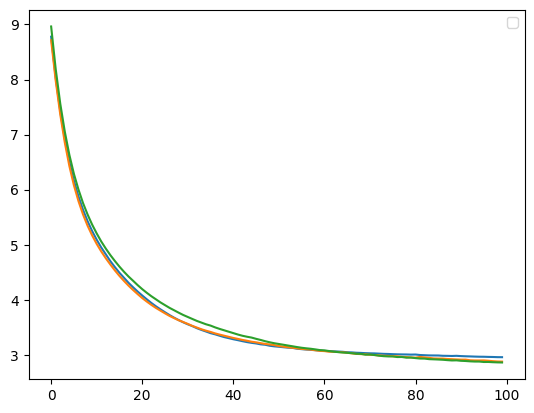

activation: tanh, regularization: 0.1, hidden_layer_elements: 10, n_hidden_layers: 5
Accuracy test: 0.17948718617359796
Accuracy train: 0.23621794829765955


Model: "sequential_99"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_339 (Dense)               │ (None, 100)            │        61,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_340 (Dense)               │ (None, 26)             │         2,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,426 (251.66 KB)

 Trainable params: 64,426 (251.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_accuracy: 0.1357 - loss: 19.2534  
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.5182 - loss: 14.1902 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.7248 - loss: 10.3852 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.8103 - loss: 7.5643 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.8816 - loss: 5.4690 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9206 - loss: 4.0145 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.9326 - loss: 2.9940 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9303 - loss: 2.3248 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9422 - loss: 1.8253 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9334 - loss: 1.5324 
Epoch 11/100
11

Model: "sequential_100"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_341 (Dense)               │ (None, 100)            │        61,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_342 (Dense)               │ (None, 26)             │         2,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,426 (251.66 KB)

 Trainable params: 64,426 (251.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_accuracy: 0.1093 - loss: 19.3064  
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.4885 - loss: 14.2377 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.7508 - loss: 10.4311 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.7949 - loss: 7.6215 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.8868 - loss: 5.4878 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9199 - loss: 4.0078 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9203 - loss: 2.9712 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9188 - loss: 2.2915 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9469 - loss: 1.8095 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.9511 - loss: 1.4973 
Epoch 11/100
11

Model: "sequential_101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_343 (Dense)               │ (None, 100)            │        61,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_344 (Dense)               │ (None, 26)             │         2,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,426 (251.66 KB)

 Trainable params: 64,426 (251.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_accuracy: 0.0967 - loss: 19.4899  
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.4890 - loss: 14.4475 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.6787 - loss: 10.6609 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.8088 - loss: 7.8130 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.8724 - loss: 5.6947 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.8693 - loss: 4.2209 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.8956 - loss: 3.1629 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.9199 - loss: 2.4266 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9333 - loss: 1.9141 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9460 - loss: 1.5581 
Epoch 11/100
11

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


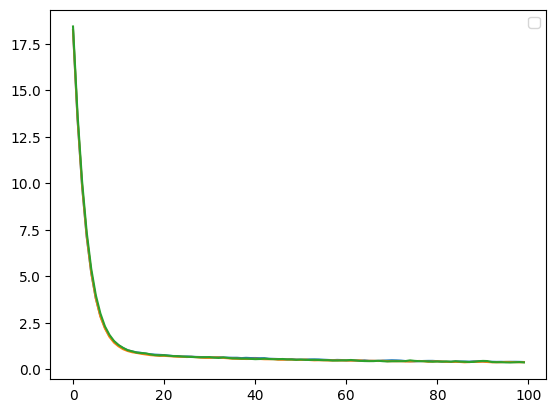

activation: tanh, regularization: 0.1, hidden_layer_elements: 100, n_hidden_layers: 1
Accuracy test: 0.932692309220632
Accuracy train: 0.9903846184412638


Model: "sequential_102"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_345 (Dense)               │ (None, 100)            │        61,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_346 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_347 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_348 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_349 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_350 (Dense)               │ (None, 26)             │         2,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,826 (409.48 KB)

 Trainable params: 104,826 (409.48 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - categorical_accuracy: 0.1311 - loss: 57.3257
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.3572 - loss: 45.5261 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.5068 - loss: 36.0146 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.5505 - loss: 28.4866 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.5935 - loss: 22.6473 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.5958 - loss: 18.1613 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.6017 - loss: 14.7212 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.5137 - loss: 12.0730 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.5457 - loss: 9.9955  
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.5123 - loss: 8.4073 
Epoch 11/10

Model: "sequential_103"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_351 (Dense)               │ (None, 100)            │        61,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_352 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_353 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_354 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_355 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_356 (Dense)               │ (None, 26)             │         2,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,826 (409.48 KB)

 Trainable params: 104,826 (409.48 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - categorical_accuracy: 0.1280 - loss: 57.4702
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.4383 - loss: 45.6135 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.5649 - loss: 36.0843 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.6148 - loss: 28.5395 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.5556 - loss: 22.7189 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.5904 - loss: 18.2130 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.5539 - loss: 14.7707 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.5400 - loss: 12.0943 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.5064 - loss: 10.0325 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.5391 - loss: 8.4058 
Epoch 11/10

Model: "sequential_104"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_357 (Dense)               │ (None, 100)            │        61,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_358 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_359 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_360 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_361 (Dense)               │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_362 (Dense)               │ (None, 26)             │         2,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,826 (409.48 KB)

 Trainable params: 104,826 (409.48 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - categorical_accuracy: 0.0866 - loss: 57.4790
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.3552 - loss: 45.5236 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.4945 - loss: 35.9233 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.5267 - loss: 28.3724 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.5890 - loss: 22.5719 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.5630 - loss: 18.0999 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.5567 - loss: 14.6653 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.5634 - loss: 11.9862 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.5284 - loss: 9.9543  
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.5385 - loss: 8.3551 
Epoch 11/10

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


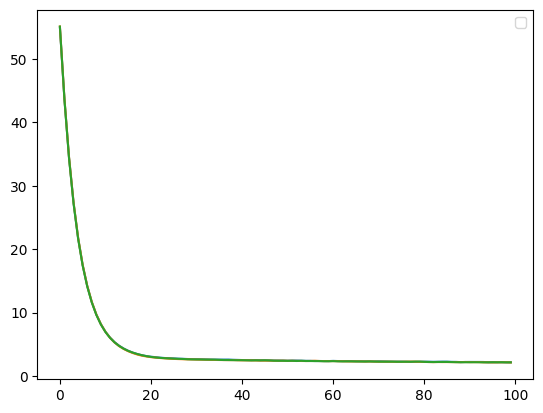

activation: tanh, regularization: 0.1, hidden_layer_elements: 100, n_hidden_layers: 5
Accuracy test: 0.6775641043980917
Accuracy train: 0.7410256266593933
Resultados:
-----------------
Best model: ('tanh', 0.0001, 100, 1)
Best model accuracy: 0.9564102490743002
-----------------
Worst model: ('tanh', 0.1, 10, 5)
Worst model accuracy: 0.17948718617359796


In [23]:
n_splits = 3
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Realizamos una búsqueda de hiperparámetros
activations = ['relu', 'tanh']
regularizations = [0.0001, 0.1]
hidden_layer_elements_list = [10, 100]
n_hidden_layers_list = [1, 5]

best_model = None
best_accuracy = None
worst_model = None
worst_accuracy = None

all_accuracies = []

for activation in activations:
    for regularization in regularizations:
        for hidden_layer_elements in hidden_layer_elements_list:
            for n_hidden_layers in n_hidden_layers_list:
                histories = []
                accuracy = []
                accuracy2 = []

                for train_index, test_index in kf.split(data):
                    X_train, X_test = data[train_index], data[test_index]
                    y_train, y_test = label[train_index], label[test_index]
                    norm = Normalize()
                    norm.fit(X_train)
                    X_train = norm.transform(X_train)
                    X_test = norm.transform(X_test)

                    fn_perdida = keras.losses.CategoricalCrossentropy() # Función de pérdida
                    optimizador = keras.optimizers.Adam(0.001) # Optimizador Adam con learning rate de 0.001
                    metrica = keras.metrics.CategoricalAccuracy() # Métrica de evaluación

                    modelo = crear_red(data, capas = n_hidden_layers, neuronas = hidden_layer_elements, alpha = regularization, activation = activation)
                    modelo.compile(optimizer=optimizador, loss=fn_perdida, metrics=[metrica])
                    history = modelo.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size)
                    histories.append(history)

                    result = modelo.evaluate(X_test, y_test)
                    result2 = modelo.evaluate(X_train, y_train)
                    accuracy.append(result[1])
                    accuracy2.append(result2[1])

                # Mostramos los gráficos de 3 en 3
                if len(histories) == 3:
                    for history in histories:
                        pyplot.plot(history.history['loss'])
                    pyplot.legend()
                    pyplot.show()
                    histories = []



                # Hacemos la media de las accuracy en los 3 folds
                accuracy = np.mean(accuracy)
                accuracy2 = np.mean(accuracy2)
                print(f'activation: {activation}, regularization: {regularization}, hidden_layer_elements: {hidden_layer_elements}, n_hidden_layers: {n_hidden_layers}')
                print(f'Accuracy test: {accuracy}')
                print(f'Accuracy train: {accuracy2}')
                all_accuracies.append((activation, regularization, hidden_layer_elements, n_hidden_layers, accuracy))

                if best_accuracy is None or accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_model = (activation, regularization, hidden_layer_elements, n_hidden_layers)
                if worst_accuracy is None or accuracy < worst_accuracy:
                    worst_accuracy = accuracy
                    worst_model = (activation, regularization, hidden_layer_elements, n_hidden_layers)


# Mostramos los resultados de forma bonita

print('Resultados:')
print('-----------------')
print('Best model:', best_model)
print('Best model accuracy:', best_accuracy)
print('-----------------')
print('Worst model:', worst_model)
print('Worst model accuracy:', worst_accuracy)


## Visualiza los resultados

Muestra [gráficas 3D](https://matplotlib.org/stable/gallery/mplot3d/surface3d.html) con la precisión en el conjunto de validación sobre siguientes ejes:

* **Regularización** vs **Número de capas**
* **Regularización** vs **Número de unidades por capa**
* **Número de capas** vs **Número de unidades por capa**

Para los parámetros no incluídos en los ejes, utiliza aquellos obtenidos que han obtenido la mejor precisión en el conjunto de validación. Razona los resultados obtenidos. ¿Qué crees que está causando la fluctuación en los resultados obtenidos?

### Observamos los resultados como tabla

In [25]:
# Imprimimos all_accuracies como tabla
print('Tabla de resultados:')
print('-'*100)
print('activation\tregularization\thidden_layer_elements\tn_hidden_layers\t\taccuracy')
for result in all_accuracies:
    # dejamos espacio para que se vea bonito
    print(f'{result[0]}\t\t{result[1]}\t\t{result[2]}\t\t\t{result[3]}\t\t\t{result[4]}')

Tabla de resultados:
----------------------------------------------------------------------------------------------------
activation	regularization	hidden_layer_elements	n_hidden_layers		accuracy
relu		0.0001		10			1			0.9051282008488973
relu		0.0001		10			5			0.7737179597218832
relu		0.0001		100			1			0.9551282127698263
relu		0.0001		100			5			0.9352564016977946
relu		0.1		10			1			0.8948717912038168
relu		0.1		10			5			0.23012820879618326
relu		0.1		100			1			0.9217948714892069
relu		0.1		100			5			0.549358973900477
tanh		0.0001		10			1			0.875
tanh		0.0001		10			5			0.7653846144676208
tanh		0.0001		100			1			0.9564102490743002
tanh		0.0001		100			5			0.9525641004244486
tanh		0.1		10			1			0.8698718150456747
tanh		0.1		10			5			0.17948718617359796
tanh		0.1		100			1			0.932692309220632
tanh		0.1		100			5			0.6775641043980917


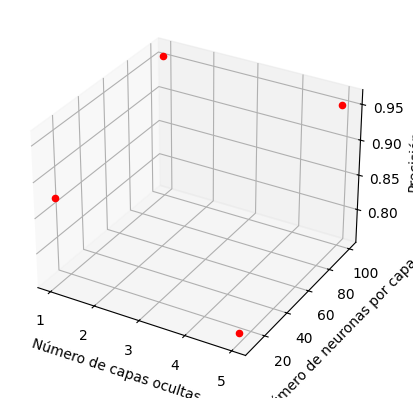

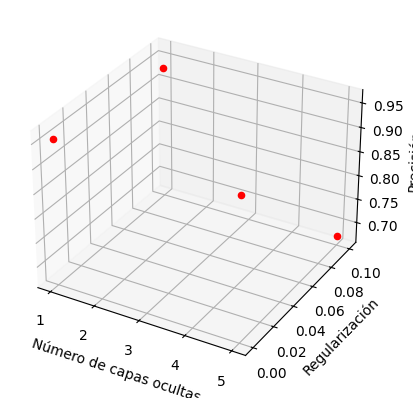

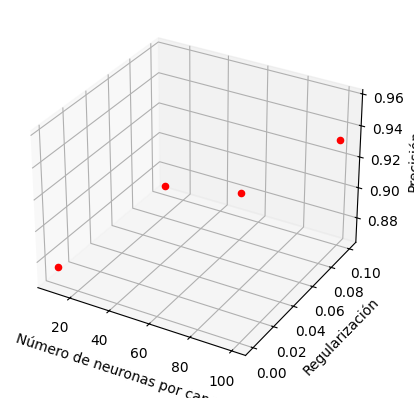

In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1. Número de capas ocultas vs Número de neuronas por capa
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for accuracy in all_accuracies:
    if accuracy[0] == best_model[0] and accuracy[1] == best_model[1]:
        ax.scatter(accuracy[3], accuracy[2], accuracy[4], c='r', marker='o')
ax.set_xlabel('Número de capas ocultas')
ax.set_ylabel('Número de neuronas por capa')
ax.set_zlabel('Precisión')
plt.show()

# 2. Número de capas ocultas vs Regularización
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for accuracy in all_accuracies:
    if accuracy[0] == best_model[0] and accuracy[2] == best_model[2]:
        ax.scatter(accuracy[3], accuracy[1], accuracy[4], c='r', marker='o')
ax.set_xlabel('Número de capas ocultas')
ax.set_ylabel('Regularización')
ax.set_zlabel('Precisión')
plt.show()

# 3. Número de neuronas por capa vs Regularización
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for accuracy in all_accuracies:
    if accuracy[0] == best_model[0] and accuracy[3] == best_model[3]:
        ax.scatter(accuracy[2], accuracy[1], accuracy[4], c='r', marker='o')
ax.set_xlabel('Número de neuronas por capa')
ax.set_ylabel('Regularización')
ax.set_zlabel('Precisión')
plt.show()
